In [ ]:
%cd /content/drive/MyDrive/boda2

!pip install pytorch-lightning==1.9
!pip install cloudml-hypertune
!pip install dmslogo
!pip install biopython

from google.colab import output
output.clear()

In [ ]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

import pickle
from datetime import datetime
import scipy.stats as stats
import math

import hypertune
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import boda
from boda.common import constants, utils
from boda.common.utils import *

from src.main import unpack_artifact, model_fn
from src.pymeme import streme, parse_streme_output
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.data import MPRA_DataModule

from boda.common.utils import batch2fasta

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import dmslogo
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
%matplotlib inline

GPU available: Tesla V100-SXM2-16GB (1 count)


In [ ]:
# class constants():
#     def __init__(self):
#         self.STANDARD_NT = ['A','C','G','T']
#         self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
# constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load Malinois

In [ ]:
model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print()

Loaded model from 20211113_021200 in eval mode



# Load CODA library

In [ ]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

coda_library_df['method_round'] = [row['method'] + '_' + str(row['round']) if row['round'] !=0 else row['method'] for _,row in coda_library_df.iterrows()]

cell_types = ['K562', 'HepG2', 'SKNSH']
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_order = [x.lower() for x in cell_types]
method_order = ['DHS', 'gs', 'sa', 'al', 'fsp', 'fsp_1', 'fsp_2', 'fsp_3', 'fsp_4', 'fsp_5']
method_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']

# Load CODA contributions

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

# Load core motifs

In [ ]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

In [ ]:
custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
                      'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
                      'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
                      'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
                      ]

#Get predictions of original sequences

In [ ]:
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

# Load core motif FIMO hits

In [ ]:
#--------- FIMO hits ----------------
#fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_low_p.tsv'
#fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_v2.tsv'
# fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv'


# full_fimo_df = pd.read_csv(fimo_file_path, sep='\t')
# full_fimo_df = full_fimo_df[:-3]

# full_fimo_df['start'] = full_fimo_df['start'].astype(int) - 1
# full_fimo_df['stop'] = full_fimo_df['stop'].astype(int)

# fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

#--------- Gradient-based motif hits ----------------
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
# fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')


fimo_df['score'] = fimo_df['gradients_pearson']
fimo_df['p_value'] = fimo_df['gradients_pearson']

# Disrupt all motif instances at once

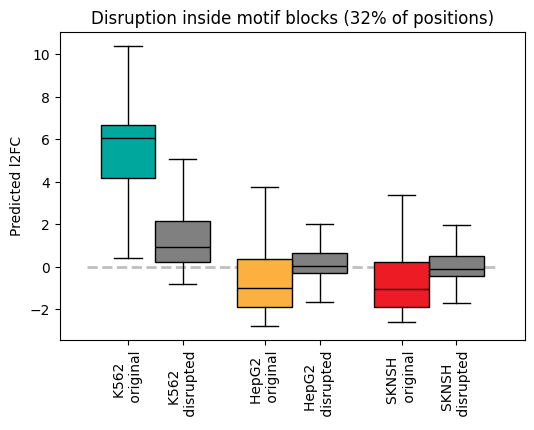

Disruption: 32.0% of positions



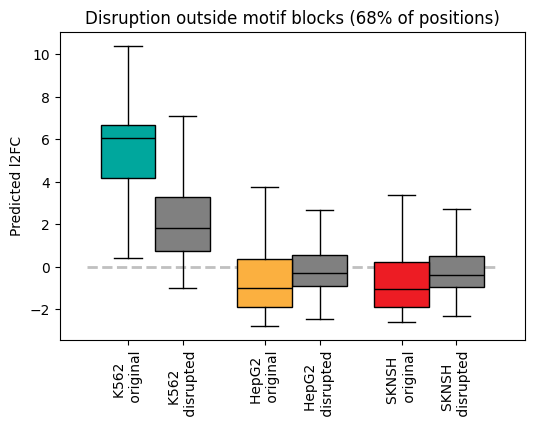

Disruption: 68.0% of positions



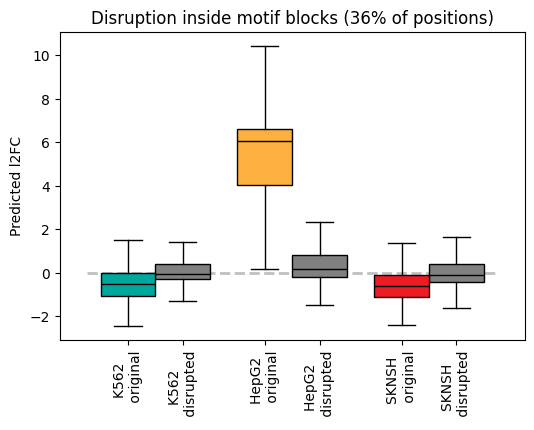

Disruption: 36.0% of positions



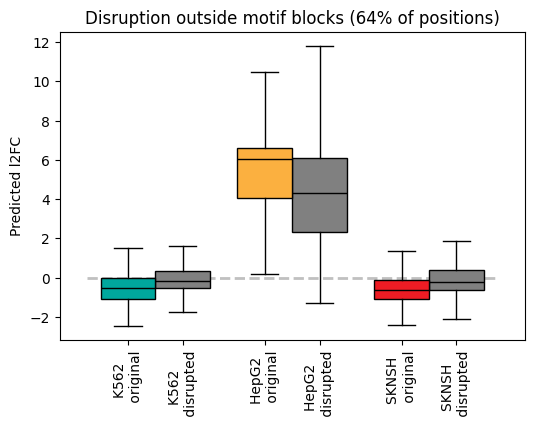

Disruption: 64.0% of positions



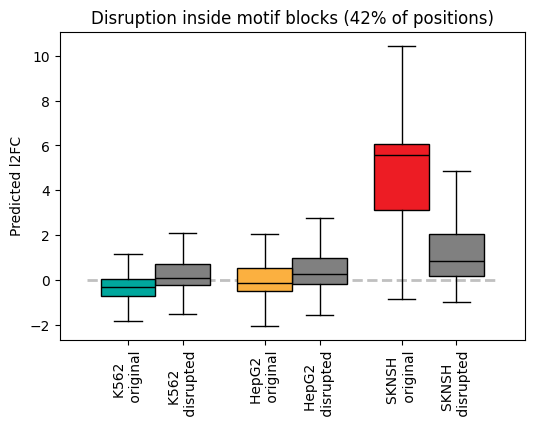

Disruption: 42.0% of positions



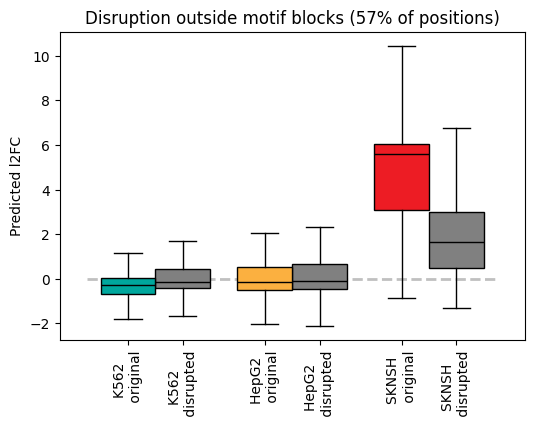

Disruption: 57.99999999999999% of positions

CPU times: user 1min 4s, sys: 5.43 s, total: 1min 10s
Wall time: 1min 12s


In [ ]:
%%time

figsize = (6, 4)

id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))
for target_cell in ['k562', 'hepg2', 'sknsh']:
    prior_subset_seq_ids = coda_library_df[coda_library_df['target_cell'] == target_cell].ID.tolist()
    subset_fimo_df = fimo_df[fimo_df['sequence_name'].isin(prior_subset_seq_ids)]
    grouped = subset_fimo_df.groupby('sequence_name')

    subset_seq_ids = list(grouped.groups.keys())
    subset_seq_idxs = [id_to_global_idx[ID] for ID in subset_seq_ids]
    #subset_onehots = seq_onehots[subset_seq_idxs, ...]
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption inside motif blocks ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------- Disruption outside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        covered_idxs = np.setdiff1d(np.arange(0, 200), covered_idxs)   #Disrupt all other positions
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside motif blocks ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

#Random motif disruption

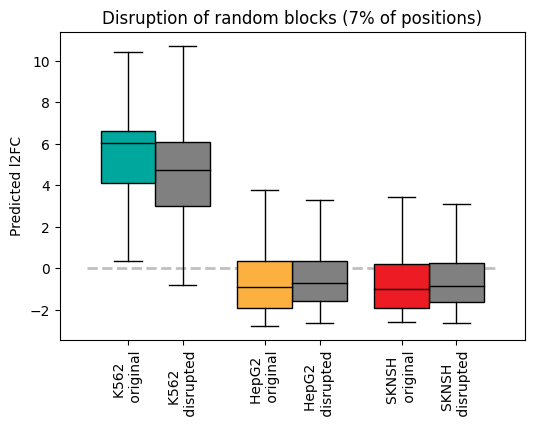

Disruption: 7.000000000000001% of positions



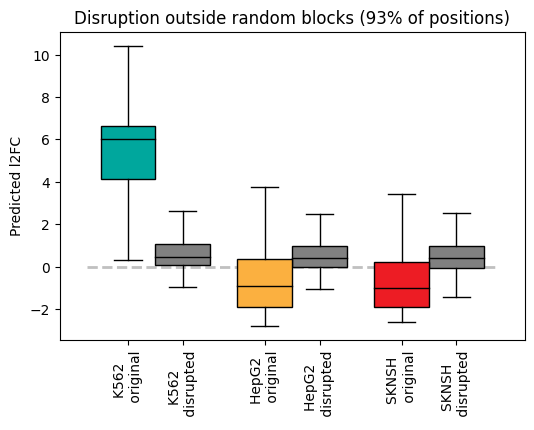

Disruption: 93.0% of positions



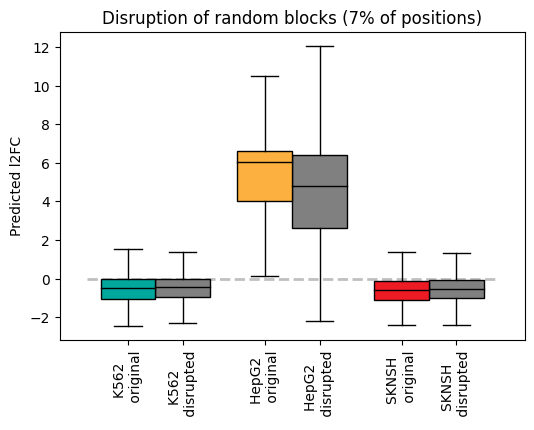

Disruption: 7.000000000000001% of positions



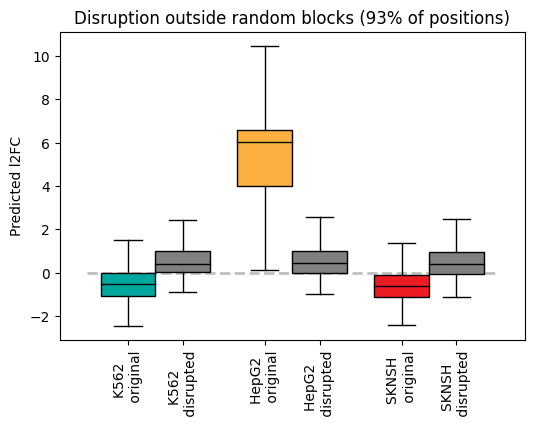

Disruption: 93.0% of positions



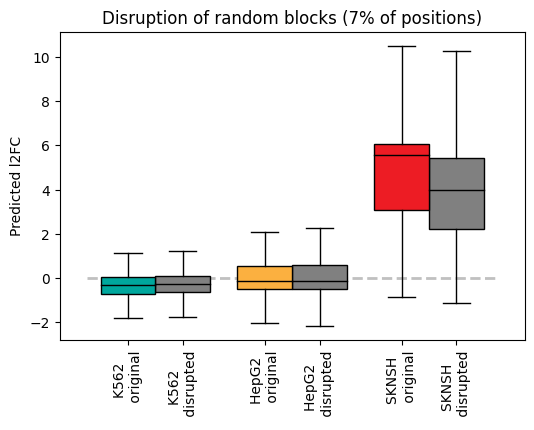

Disruption: 7.000000000000001% of positions



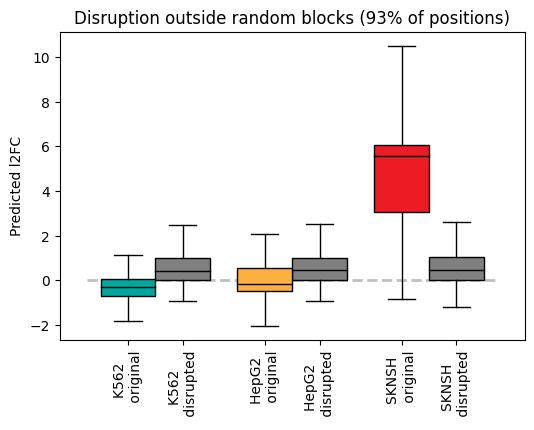

Disruption: 93.0% of positions



In [ ]:
figsize = (6, 4)
id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

for target_cell in ['k562', 'hepg2', 'sknsh']:
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    all_covered_idxs = {}
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.unique(np.concatenate([np.arange(start, start + 7) for start in np.random.randint(0, 190, 2)]))
        all_covered_idxs[seq_id] = covered_idxs
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of random blocks ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------ Complement disruption ----------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.setdiff1d(np.arange(0, 200), all_covered_idxs[seq_id])
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside random blocks ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

#Contribution block disruption

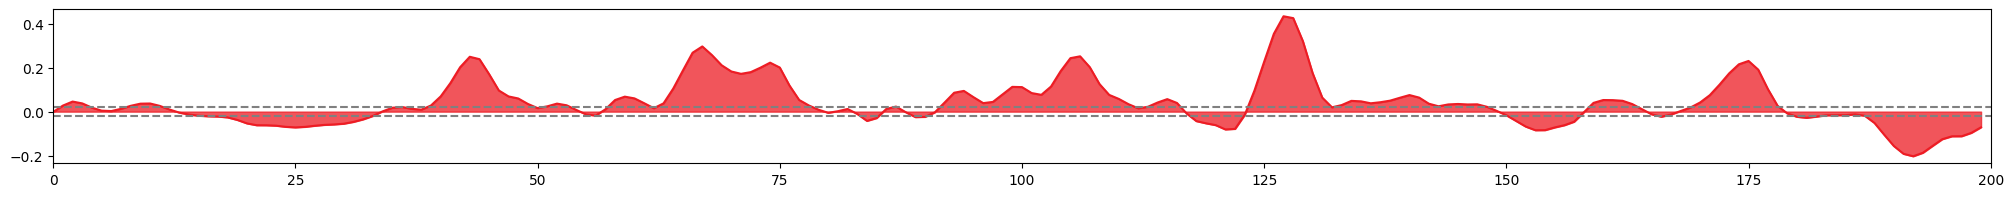

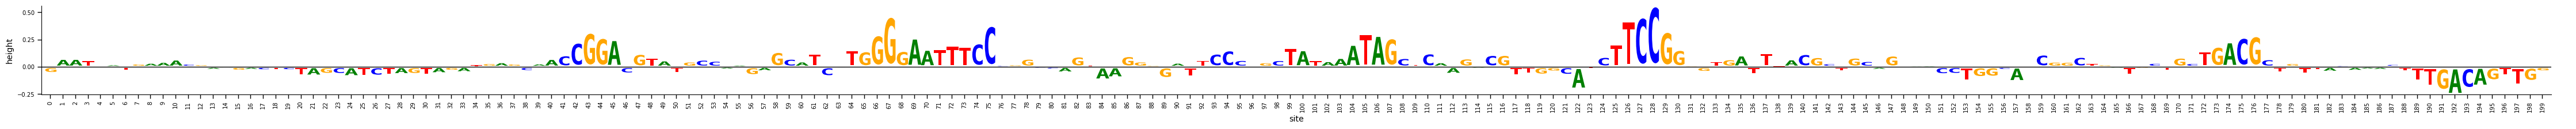

In [ ]:
# cell_idx = 2

# sigma = 1.35
# pos_threshold = 0.02
# neg_threshold = -0.02

seq_cell_contributions = all_contributions[cell_idx, seq_idx, ...]
seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
T = np.arange(0, seq_flat_contributions.shape[0])
ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

figsize = (25,2)
color = cell_colors[cell_idx]

fig, ax = plt.subplots(figsize=figsize)
ax.plot(T, ysmoothed, color=color, label='MPRA tiling')
ax.fill_between(range(len(ysmoothed)), ysmoothed, alpha=0.75, color=color)
ax.hlines(threshold, 0, 200, linestyles='dashed', color='gray')
ax.hlines(-threshold, 0, 200, linestyles='dashed', color='gray')
plt.margins(x=0)
plt.show()

matrix_to_dms(seq_cell_contributions, y_max=seq_cell_contributions.max().item())
plt.show()

### Positive blocks in target cell

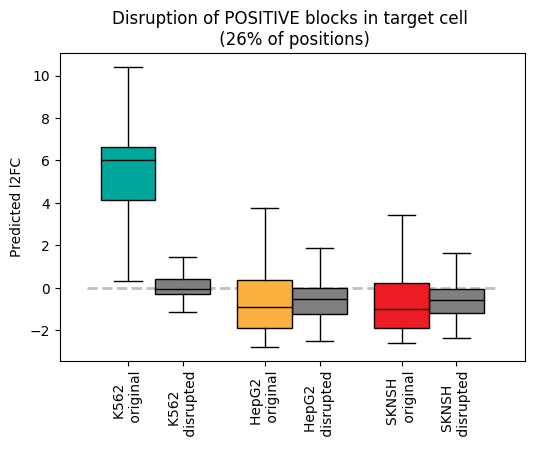

Disruption: 26.0% of positions



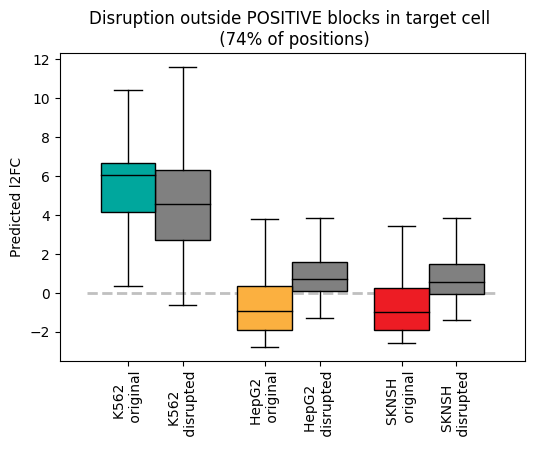

Disruption: 74.0% of positions



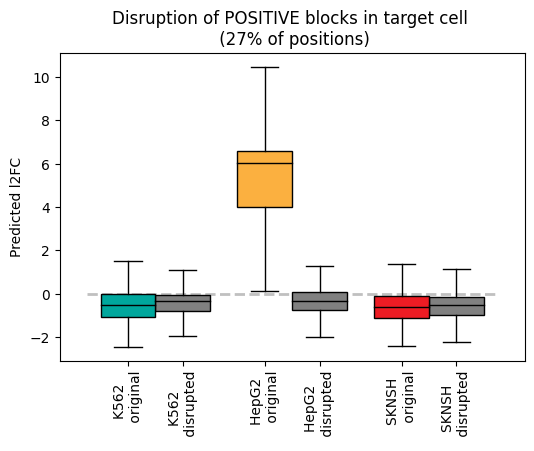

Disruption: 27.0% of positions



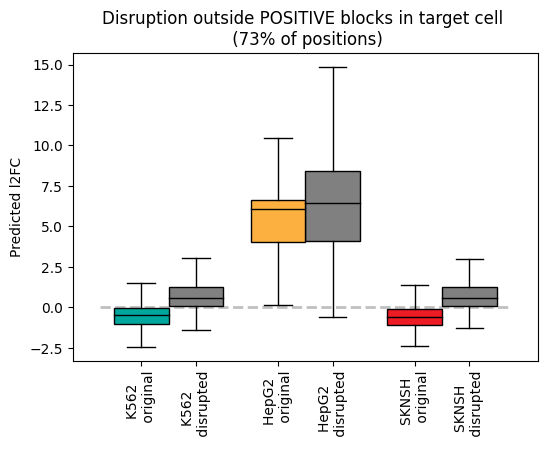

Disruption: 73.0% of positions



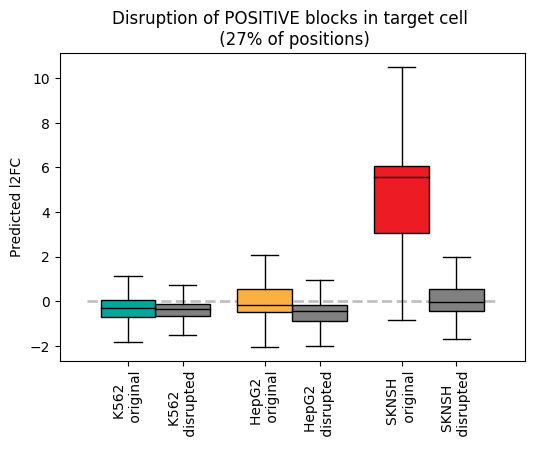

Disruption: 27.0% of positions



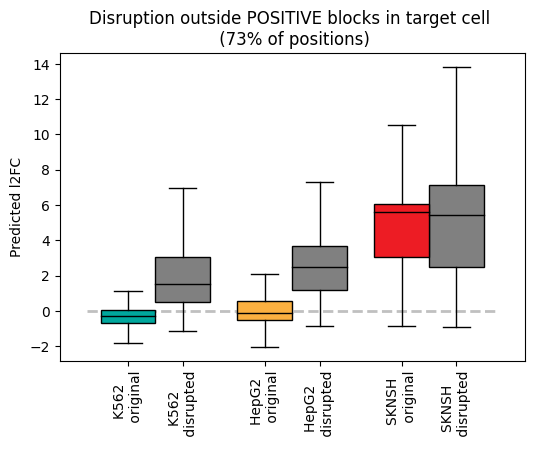

Disruption: 73.0% of positions



In [ ]:
sigma = 1.15
min_lens = [5, 5, 5]
min_means = [0.05, 0.05, 0.075]
threshold = 0.015

figsize = (6, 4)
id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

for cell_idx, target_cell in enumerate(['k562', 'hepg2', 'sknsh']):
    min_len = min_lens[cell_idx]
    min_mean = min_means[cell_idx]
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    all_covered_idxs = {}
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        seq_cell_contributions = all_contributions[cell_idx, seq_idx, ...]
        seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
        ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

        pos_differences = ysmoothed - threshold
        pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

        covered_idxs = []
        if len(pos_cross_idxs) > 0:
            if pos_cross_idxs[0] != 0:
                pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
            start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

            if len(start_stops) > 0:
                for start, stop in start_stops:
                    window_len = stop - start
                    window_scores = seq_flat_contributions[start:stop]
                    window_mean_score = window_scores.mean()
                    if window_mean_score >= min_mean and window_len >= min_len:
                        covered_idxs.append(np.arange(start, stop))
        if len(covered_idxs) > 0:
            covered_idxs = np.concatenate(covered_idxs)
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            random_tokens = torch.randint(0, 4, (len(covered_idxs),))
            random_onehot = torch.zeros(4, len(covered_idxs))
            random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
            motif_disrupted_seq[..., covered_idxs] = random_onehot
        else:
            covered_idxs = np.empty(shape=(0, 0))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        motif_disrupted_seqs.append(motif_disrupted_seq)

        coverage_sizes.append(len(covered_idxs))
        all_covered_idxs[seq_id] = covered_idxs

    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of POSITIVE blocks in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------ Complement disruption ----------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.setdiff1d(np.arange(0, 200), all_covered_idxs[seq_id])
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside POSITIVE blocks in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

###Negative blocks in target cell

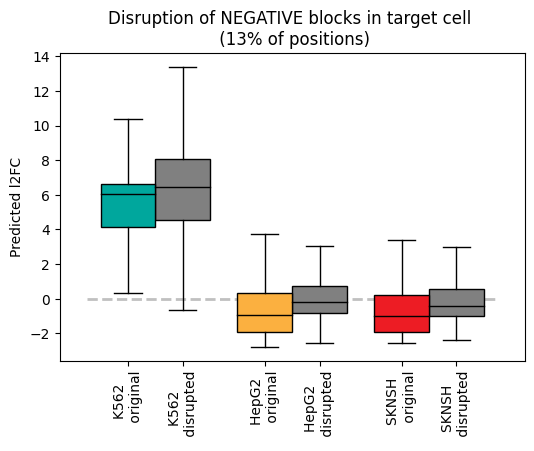

Disruption: 13.0% of positions



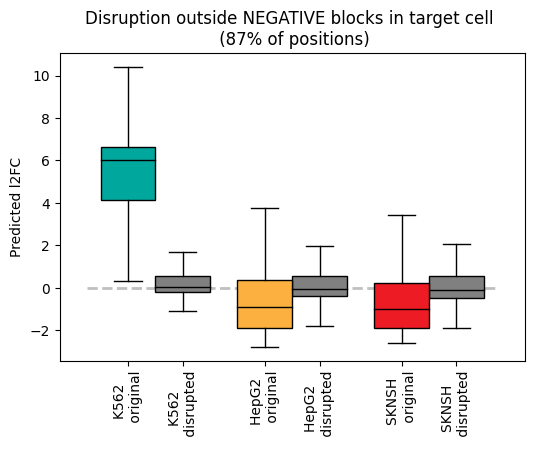

Disruption: 87.0% of positions



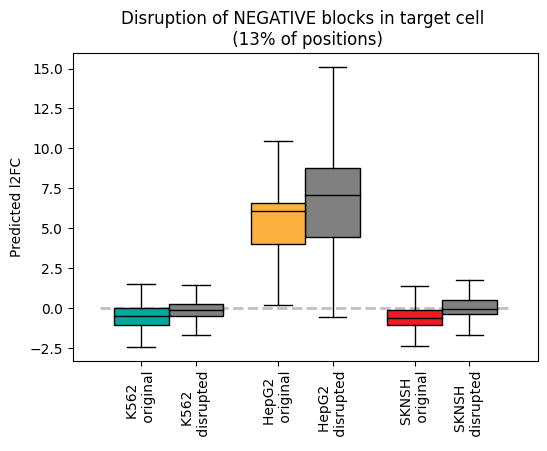

Disruption: 13.0% of positions



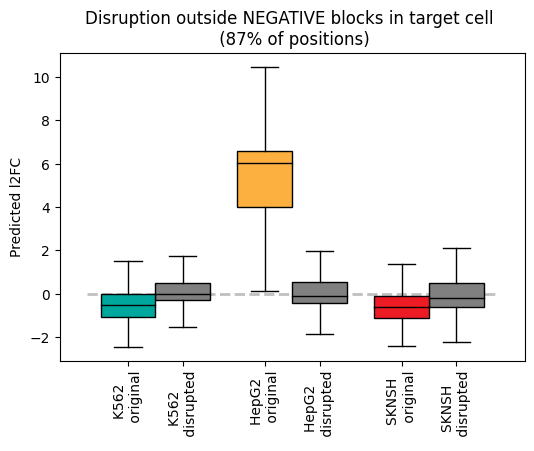

Disruption: 87.0% of positions



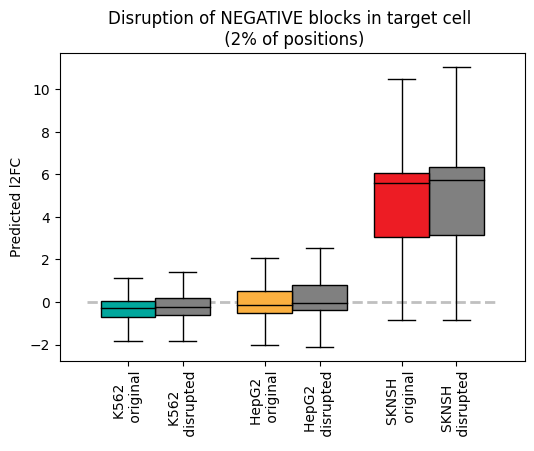

Disruption: 2.0% of positions



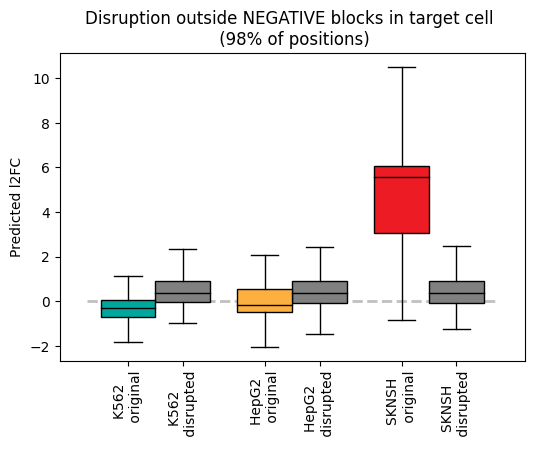

Disruption: 98.0% of positions



In [ ]:
sigma = 1.15
min_lens = [5, 5, 4]
min_mean = [0.075, 0.075, 0.05]
threshold = 0.015

figsize = (6, 4)
id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

for cell_idx, target_cell in enumerate(['k562', 'hepg2', 'sknsh']):
    min_len = min_lens[cell_idx]
    min_mean = min_means[cell_idx]
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    all_covered_idxs = {}
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        seq_cell_contributions = all_contributions[cell_idx, seq_idx, ...]
        seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
        ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

        pos_differences = ysmoothed + threshold                                         #control for direction
        pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

        covered_idxs = []
        if len(pos_cross_idxs) > 0:
            if pos_cross_idxs[0] != 0:
                pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
            start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

            if len(start_stops) > 0:
                for start, stop in start_stops:
                    window_len = stop - start
                    window_scores = seq_flat_contributions[start:stop]
                    window_mean_score = window_scores.mean()
                    if window_mean_score <= -min_mean and window_len >= min_len:        #control for direction
                        covered_idxs.append(np.arange(start, stop))
        if len(covered_idxs) > 0:
            covered_idxs = np.concatenate(covered_idxs)
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            random_tokens = torch.randint(0, 4, (len(covered_idxs),))
            random_onehot = torch.zeros(4, len(covered_idxs))
            random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
            motif_disrupted_seq[..., covered_idxs] = random_onehot
        else:
            covered_idxs = np.empty(shape=(0, 0))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        motif_disrupted_seqs.append(motif_disrupted_seq)

        coverage_sizes.append(len(covered_idxs))
        all_covered_idxs[seq_id] = covered_idxs

    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of NEGATIVE blocks in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------ Complement disruption ----------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.setdiff1d(np.arange(0, 200), all_covered_idxs[seq_id])
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside NEGATIVE blocks in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

###Disrupting positive blocks in target cell and negative blocks in off-target cells

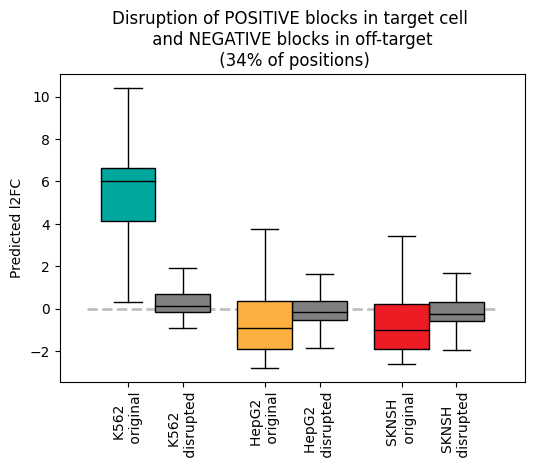

Disruption: 34.0% of positions



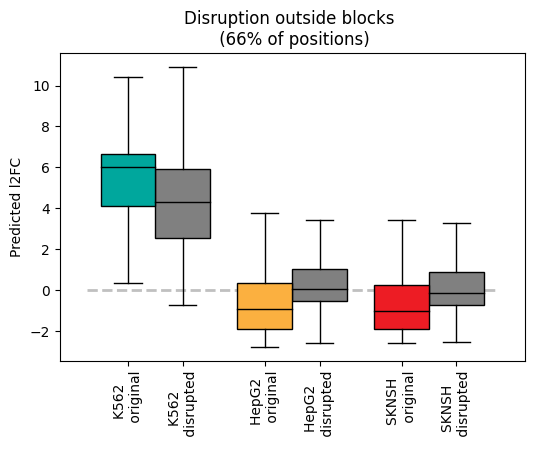

Disruption: 66.0% of positions



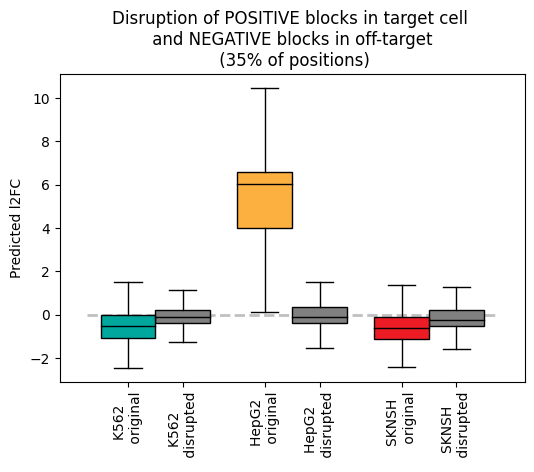

Disruption: 35.0% of positions



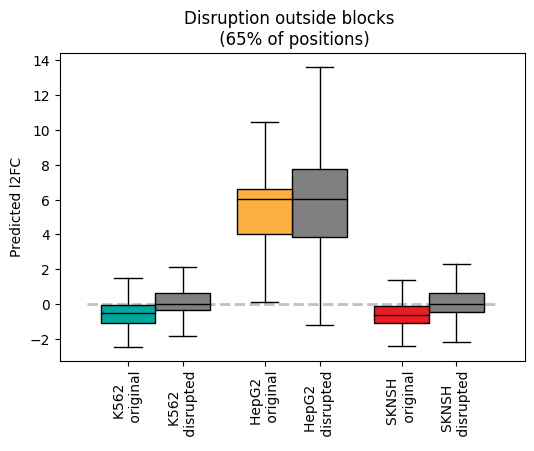

Disruption: 65.0% of positions



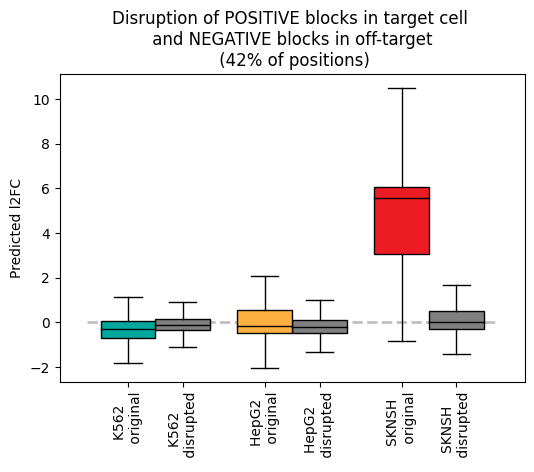

Disruption: 42.0% of positions



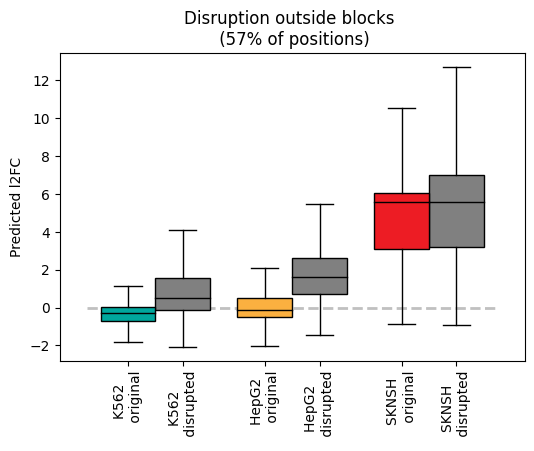

Disruption: 57.99999999999999% of positions



In [ ]:
sigma = 1.15 #1.15
min_lens = [4, 4, 4]
min_means = [0.05, 0.05, 0.05]
threshold = 0.015

figsize = (6, 4)
id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

for cell_idx, target_cell in enumerate(['k562', 'hepg2', 'sknsh']):
    min_len = min_lens[cell_idx]
    min_mean = min_means[cell_idx]
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    coverage_sizes = []
    motif_disrupted_seqs = []
    all_covered_idxs = {}
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = []
        #------- Disruption inside positive blocks in target cell --------
        seq_cell_contributions = all_contributions[cell_idx, seq_idx, ...]
        seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
        ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

        pos_differences = ysmoothed - threshold
        pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

        if len(pos_cross_idxs) > 0:
            if pos_cross_idxs[0] != 0:
                pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
            start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

            if len(start_stops) > 0:
                for start, stop in start_stops:
                    window_len = stop - start
                    window_scores = seq_flat_contributions[start:stop]
                    window_mean_score = window_scores.mean()
                    if window_mean_score >= min_mean and window_len >= min_len:
                        covered_idxs.append(np.arange(start, stop))

        #------- Blocks in off-target cells
        off_target_cell_idxs = [0, 1, 2]
        off_target_cell_idxs.remove(cell_idx)
        for off_target_cell_idx in off_target_cell_idxs:
            seq_cell_contributions = all_contributions[off_target_cell_idx, seq_idx, ...]
            seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
            ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

            neg_differences = ysmoothed + threshold
            neg_cross_idxs = np.where((np.sign(neg_differences * np.roll(neg_differences, 1)) < 1 ))[0]

            if len(neg_cross_idxs) > 0:
                if neg_cross_idxs[0] != 0:
                    neg_cross_idxs = np.concatenate([np.zeros(1), neg_cross_idxs, np.array([neg_differences.shape[0]])]).astype(int)
                start_stops = [(neg_cross_idxs[i-1], neg_cross_idxs[i]) for i in range(1, len(neg_cross_idxs))]

                if len(start_stops) > 0:
                    for start, stop in start_stops:
                        window_len = stop - start
                        window_scores = seq_flat_contributions[start:stop]
                        window_mean_score = window_scores.mean()
                        if window_mean_score <= -min_mean and window_len >= min_len:
                            covered_idxs.append(np.arange(start, stop))

        if len(covered_idxs) > 0:
            covered_idxs = np.unique(np.concatenate(covered_idxs))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            random_tokens = torch.randint(0, 4, (len(covered_idxs),))
            random_onehot = torch.zeros(4, len(covered_idxs))
            random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
            motif_disrupted_seq[..., covered_idxs] = random_onehot
        else:
            covered_idxs = np.empty(shape=(0, 0))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        motif_disrupted_seqs.append(motif_disrupted_seq)

        coverage_sizes.append(len(covered_idxs))
        all_covered_idxs[seq_id] = covered_idxs

    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of POSITIVE blocks in target cell \n and NEGATIVE blocks in off-target \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------ Complement disruption ----------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.setdiff1d(np.arange(0, 200), all_covered_idxs[seq_id])
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside blocks \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

###Disrupting negative blocks in off-target cells

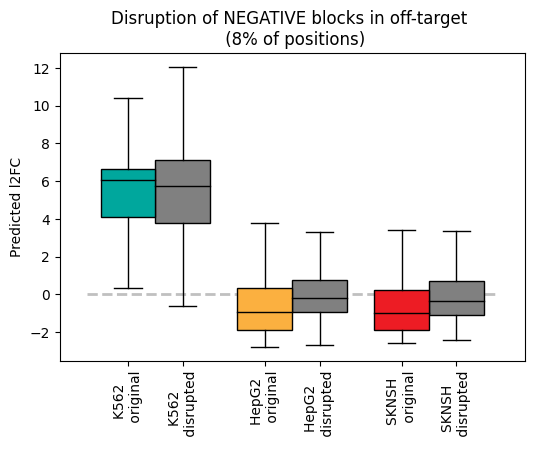

Disruption: 8.0% of positions



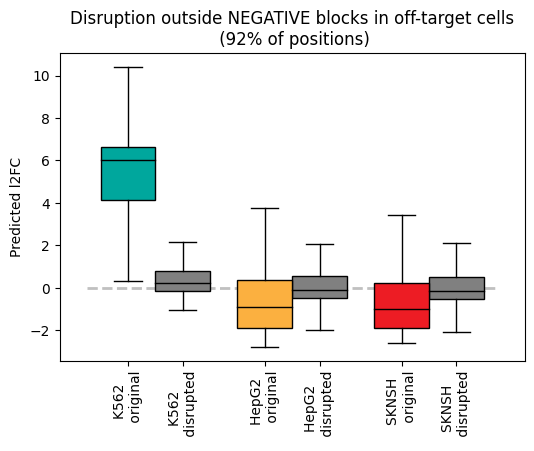

Disruption: 92.0% of positions



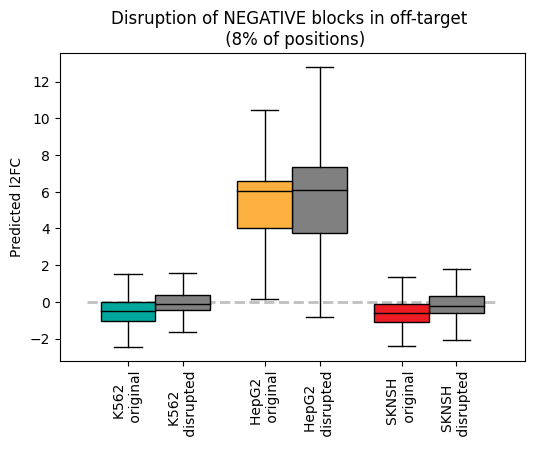

Disruption: 8.0% of positions



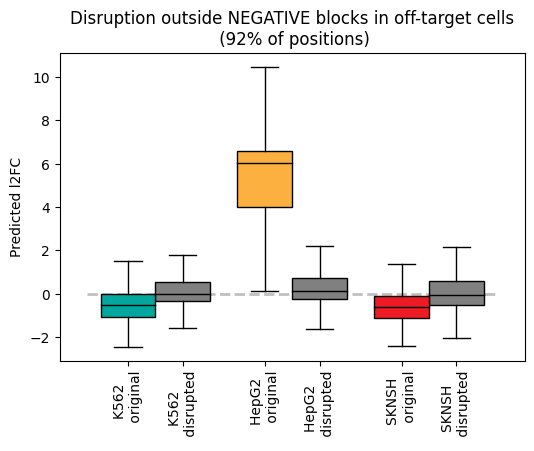

Disruption: 92.0% of positions



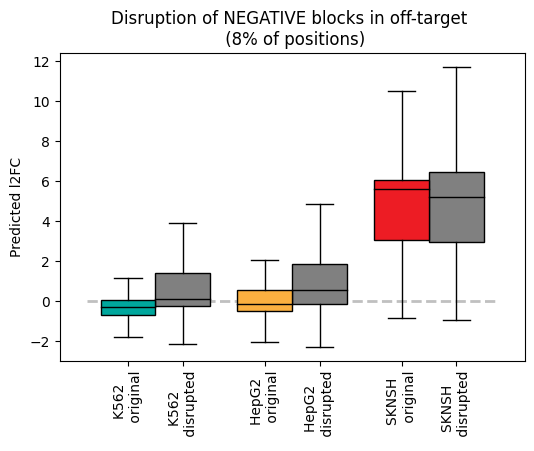

Disruption: 8.0% of positions



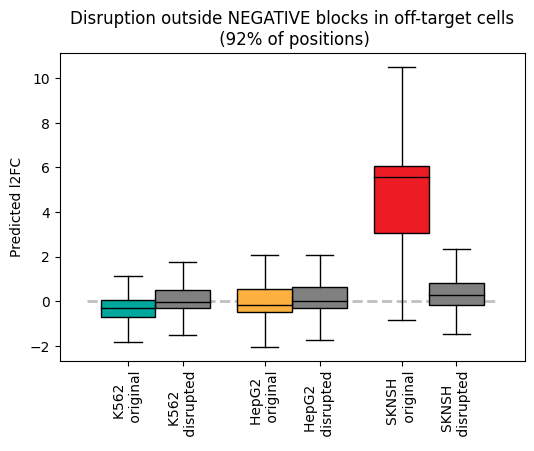

Disruption: 92.0% of positions



In [ ]:
sigma = 1.15 #1.15
min_lens = [4, 4, 4]
min_means = [0.05, 0.05, 0.05]
threshold = 0.015

figsize = (6, 4)
id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

for cell_idx, target_cell in enumerate(['k562', 'hepg2', 'sknsh']):
    min_len = min_lens[cell_idx]
    min_mean = min_means[cell_idx]
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    coverage_sizes = []
    motif_disrupted_seqs = []
    all_covered_idxs = {}
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = []
        #------- Disruption inside positive blocks in target cell --------
        # seq_cell_contributions = all_contributions[cell_idx, seq_idx, ...]
        # seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
        # ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

        # pos_differences = ysmoothed - threshold
        # pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]
        # if len(pos_cross_idxs) > 0:
        #     if pos_cross_idxs[0] != 0:
        #         pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
        #     start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

        #     if len(start_stops) > 0:
        #         for start, stop in start_stops:
        #             window_len = stop - start
        #             window_scores = seq_flat_contributions[start:stop]
        #             window_mean_score = window_scores.mean()
        #             if window_mean_score >= min_mean and window_len >= min_len:
        #                 covered_idxs.append(np.arange(start, stop))

        #------- Blocks in off-target cells
        off_target_cell_idxs = [0, 1, 2]
        off_target_cell_idxs.remove(cell_idx)
        for off_target_cell_idx in off_target_cell_idxs:
            seq_cell_contributions = all_contributions[off_target_cell_idx, seq_idx, ...]
            seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
            ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

            neg_differences = ysmoothed + threshold
            neg_cross_idxs = np.where((np.sign(neg_differences * np.roll(neg_differences, 1)) < 1 ))[0]

            if len(neg_cross_idxs) > 0:
                if neg_cross_idxs[0] != 0:
                    neg_cross_idxs = np.concatenate([np.zeros(1), neg_cross_idxs, np.array([neg_differences.shape[0]])]).astype(int)
                start_stops = [(neg_cross_idxs[i-1], neg_cross_idxs[i]) for i in range(1, len(neg_cross_idxs))]

                if len(start_stops) > 0:
                    for start, stop in start_stops:
                        window_len = stop - start
                        window_scores = seq_flat_contributions[start:stop]
                        window_mean_score = window_scores.mean()
                        if window_mean_score <= -min_mean and window_len >= min_len:
                            covered_idxs.append(np.arange(start, stop))

        if len(covered_idxs) > 0:
            covered_idxs = np.unique(np.concatenate(covered_idxs))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            random_tokens = torch.randint(0, 4, (len(covered_idxs),))
            random_onehot = torch.zeros(4, len(covered_idxs))
            random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
            motif_disrupted_seq[..., covered_idxs] = random_onehot
        else:
            covered_idxs = np.empty(shape=(0, 0))
            motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        motif_disrupted_seqs.append(motif_disrupted_seq)

        coverage_sizes.append(len(covered_idxs))
        all_covered_idxs[seq_id] = covered_idxs

    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of NEGATIVE blocks in off-target \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------ Complement disruption ----------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
        covered_idxs = np.setdiff1d(np.arange(0, 200), all_covered_idxs[seq_id])
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    preds = []
    for local_batch in temp_dataloader:
        preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside NEGATIVE blocks in off-target cells\n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

#Disrupt core motifs by cell type

In [ ]:
full_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t')

pos_motifs = motif_ids[:-8]
neg_motifs = motif_ids[-8:]

###Disrupting activators in target cell

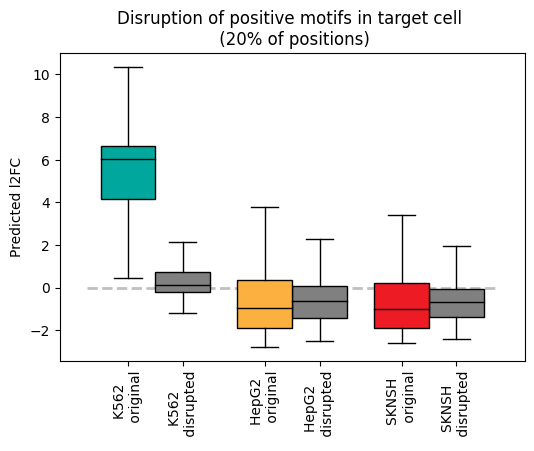

Disruption: 20.0% of positions



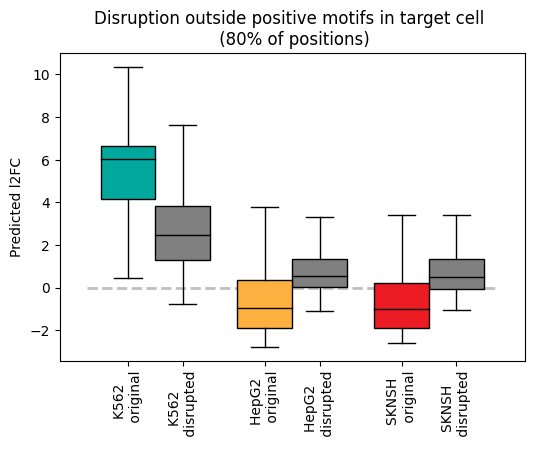

Disruption: 80.0% of positions



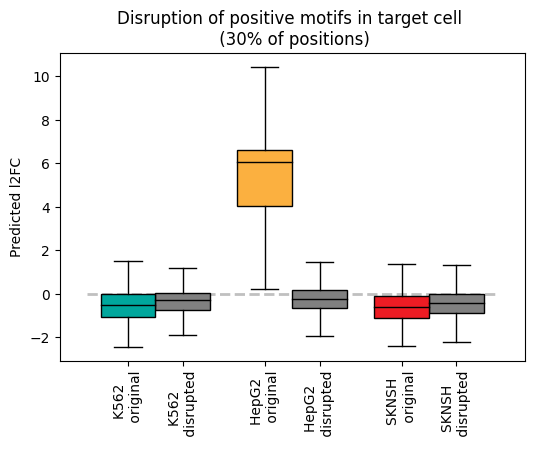

Disruption: 30.0% of positions



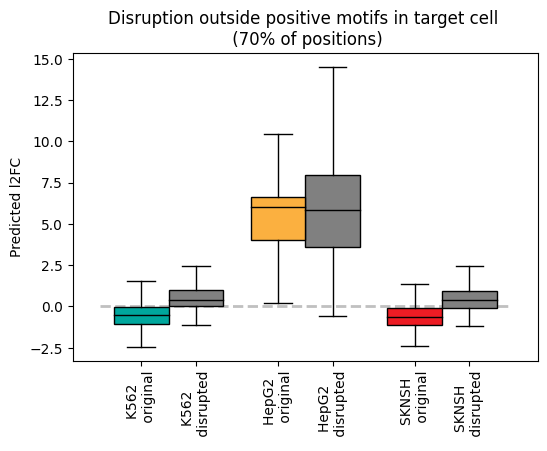

Disruption: 70.0% of positions



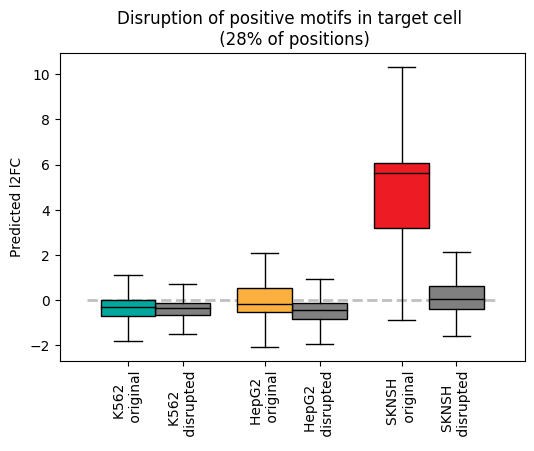

Disruption: 28.999999999999996% of positions



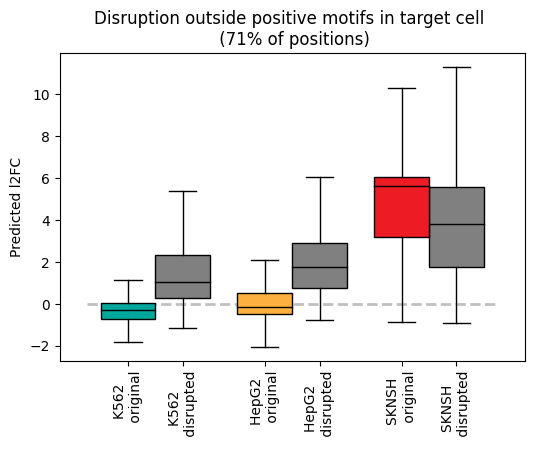

Disruption: 71.0% of positions



In [ ]:
figsize = (6, 4)

id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))
for target_cell in ['k562', 'hepg2', 'sknsh']:
    fimo_df = full_fimo_df[(full_fimo_df['cell_type'].str.lower() == target_cell) & (full_fimo_df['motif_id'].isin(pos_motifs))]
    prior_subset_seq_ids = coda_library_df[coda_library_df['target_cell'] == target_cell].ID.tolist()
    subset_fimo_df = fimo_df[fimo_df['sequence_name'].isin(prior_subset_seq_ids)]
    grouped = subset_fimo_df.groupby('sequence_name')

    subset_seq_ids = list(grouped.groups.keys())
    subset_seq_idxs = [id_to_global_idx[ID] for ID in subset_seq_ids]
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------- Disruption outside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        covered_idxs = np.setdiff1d(np.arange(0, 200), covered_idxs)   #Disrupt all other positions
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

###Disrupting repressors in target cell

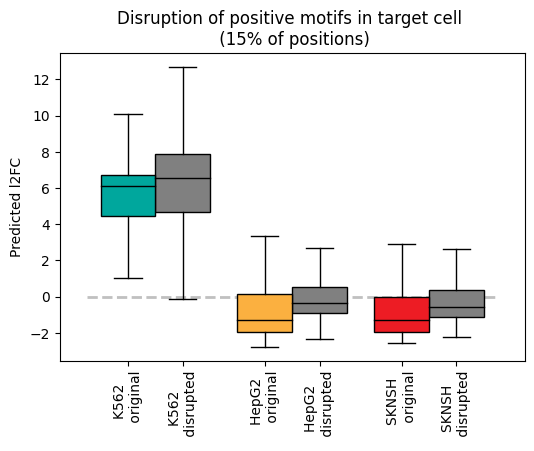

Disruption: 15.0% of positions



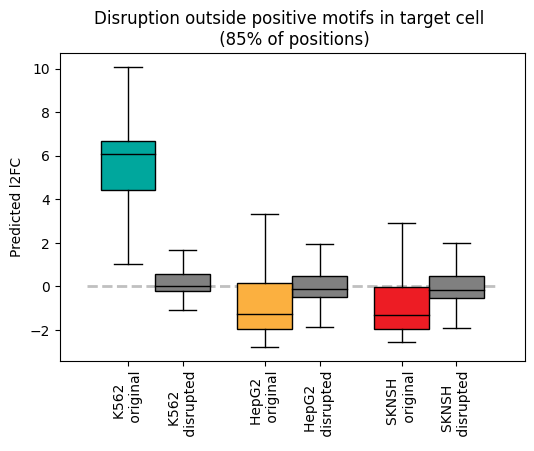

Disruption: 85.0% of positions



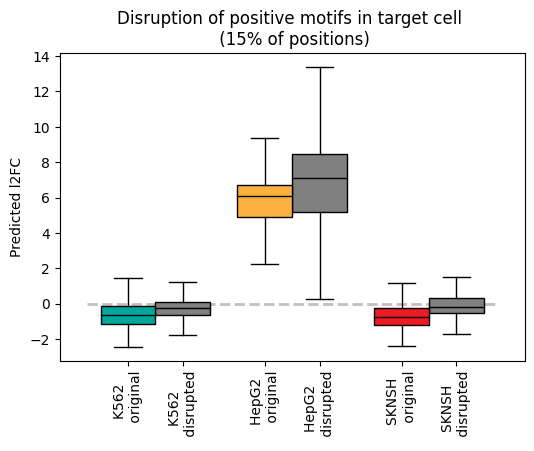

Disruption: 15.0% of positions



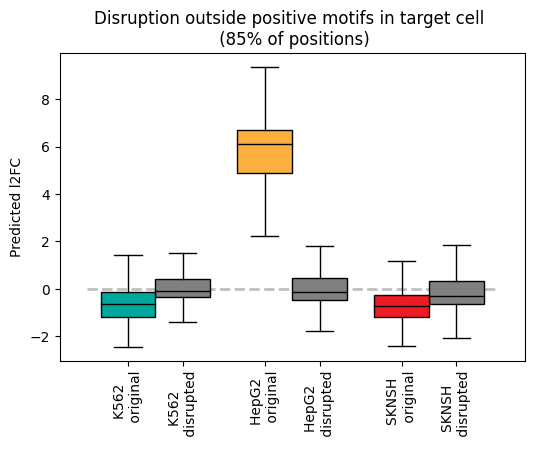

Disruption: 85.0% of positions



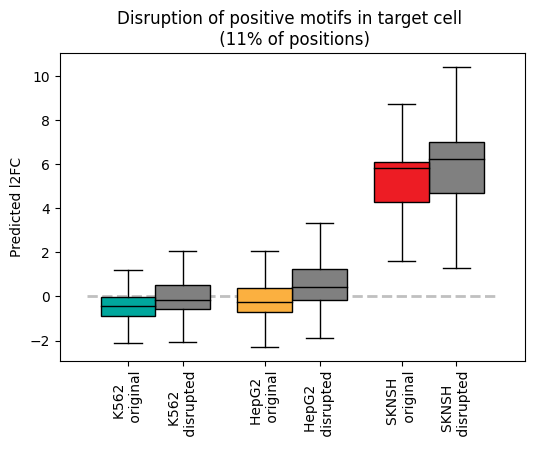

Disruption: 11.0% of positions



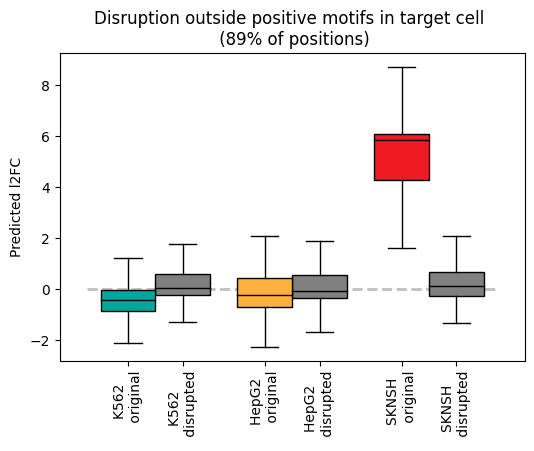

Disruption: 89.0% of positions



In [ ]:
for target_cell in ['k562', 'hepg2', 'sknsh']:
    fimo_df = full_fimo_df[(full_fimo_df['cell_type'].str.lower() == target_cell) & (full_fimo_df['motif_id'].isin(neg_motifs))]
    prior_subset_seq_ids = coda_library_df[coda_library_df['target_cell'] == target_cell].ID.tolist()
    subset_fimo_df = fimo_df[fimo_df['sequence_name'].isin(prior_subset_seq_ids)]
    grouped = subset_fimo_df.groupby('sequence_name')

    subset_seq_ids = list(grouped.groups.keys())
    subset_seq_idxs = [id_to_global_idx[ID] for ID in subset_seq_ids]
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------- Disruption outside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        covered_idxs = np.setdiff1d(np.arange(0, 200), covered_idxs)   #Disrupt all other positions
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

###Disrupting core-motif repressors in off-target cells

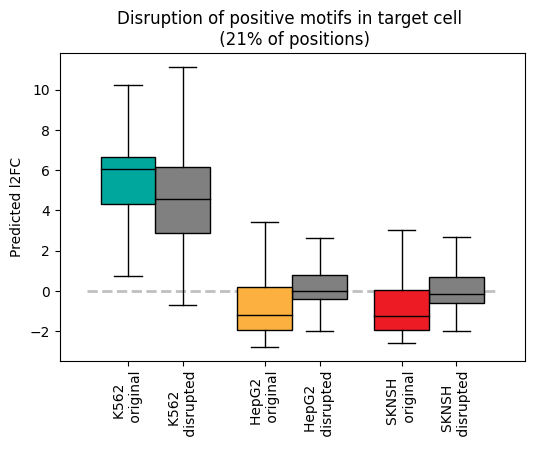

Disruption: 21.0% of positions



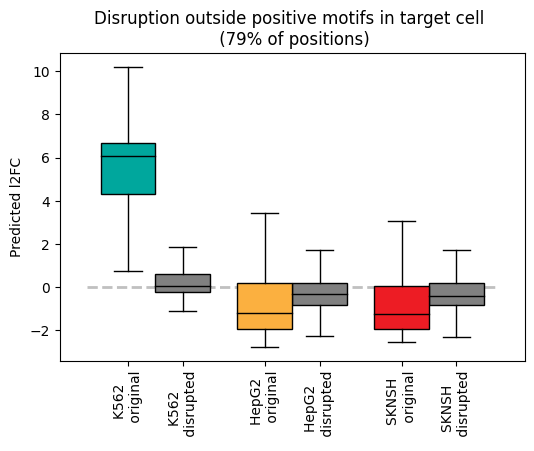

Disruption: 79.0% of positions



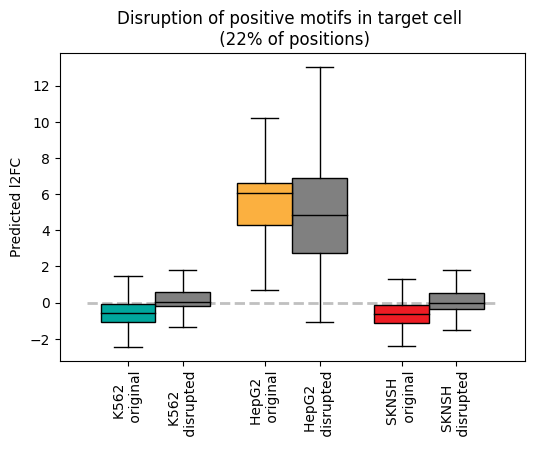

Disruption: 22.0% of positions



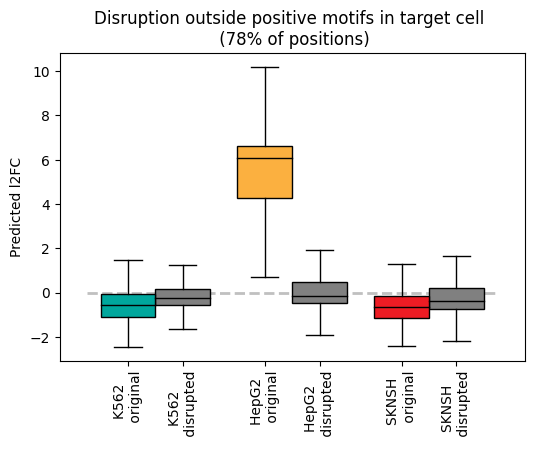

Disruption: 78.0% of positions



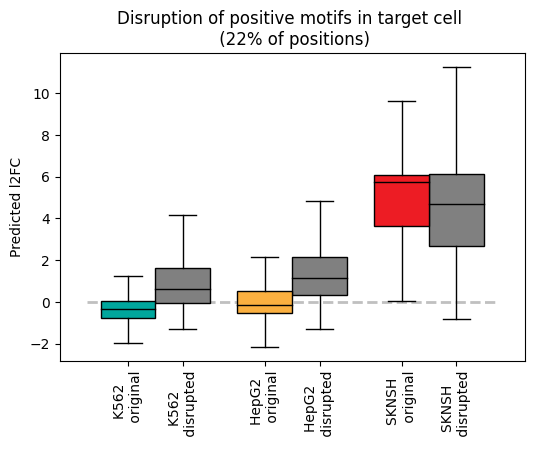

Disruption: 22.0% of positions



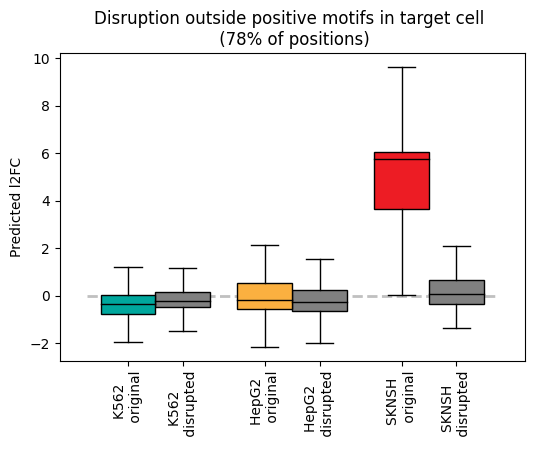

Disruption: 78.0% of positions



In [ ]:
for target_cell in ['k562', 'hepg2', 'sknsh']:
    fimo_df = full_fimo_df[(full_fimo_df['cell_type'].str.lower() != target_cell) & (full_fimo_df['motif_id'].isin(neg_motifs))]
    prior_subset_seq_ids = coda_library_df[coda_library_df['target_cell'] == target_cell].ID.tolist()
    subset_fimo_df = fimo_df[fimo_df['sequence_name'].isin(prior_subset_seq_ids)]
    grouped = subset_fimo_df.groupby('sequence_name')

    subset_seq_ids = list(grouped.groups.keys())
    subset_seq_idxs = [id_to_global_idx[ID] for ID in subset_seq_ids]
    subset_preds = original_preds[subset_seq_idxs, ...]

    #------- Disruption inside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption of positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()

    #------- Disruption outside motifs --------
    coverage_sizes = []
    motif_disrupted_seqs = []
    for seq_id, group in grouped:
        seq_idx = id_to_global_idx[seq_id]
        covered_idxs = np.unique(np.concatenate([np.arange(start, stop) for start, stop in \
                                                zip(group.start.tolist(), group.stop.tolist())]))
        covered_idxs = covered_idxs[(covered_idxs < 200) & (covered_idxs >= 0)]
        covered_idxs = np.setdiff1d(np.arange(0, 200), covered_idxs)   #Disrupt all other positions
        motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        random_onehot = torch.zeros(4, len(covered_idxs))
        random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        motif_disrupted_seq[..., covered_idxs] = random_onehot
        motif_disrupted_seqs.append(motif_disrupted_seq)
        coverage_sizes.append(len(covered_idxs))
    motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

    onehots = motif_disrupted_seqs.clone()
    #--- Predict ----
    left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
    right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
    pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
            onehots,
            right_flank.repeat(onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)
    temp_dataset = TensorDataset(in_tensor)
    temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
    disrupted_preds = []
    for local_batch in temp_dataloader:
        disrupted_preds.append(model(local_batch[0].cuda()).detach().cpu())
    #---
    disrupted_preds = torch.cat(disrupted_preds, dim=0)

    plt.figure(figsize=figsize)
    plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='silver', alpha=1, linewidth=2)
    boxplot = plt.boxplot(disrupted_preds.numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n disrupted' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(subset_preds.numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'{cell_type} \n original' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Disruption outside positive motifs in target cell \n ({int(100*np.round(disrupted_pct, 2))}% of positions)')
    plt.show()

    print(f'Disruption: {100*np.round(disrupted_pct, 2)}% of positions')
    print()